# Jakarta Smart City Data Analysis 

Andi Muhammad Imam Akbar Abdullah

### This project analysises how urban mobility (traffic), waste management, and environmental conditions (air quality) relate to citizen perception (public complaints) to assess Jakarta’s smart city performance.

Required Libraries:
- pandas 
- numpy 
- matplotlib 
- seaborn 
- plotly 
- geopandas 
- folium


Used Dataset:
- [Daily Air Quality Index (AQI) in Jakarta from January 2010 - February 2025](https://www.kaggle.com/datasets/senadu34/air-quality-index-in-jakarta-2010-2021/code)
- [Kecepatan Rata-rata di Ruas Jalan yang Dikenakan Kebijakan Pembatasan Lalu Lintas pada Jam Sibuk](https://satudata.jakarta.go.id/open-data/detail?kategori=dataset&page_url=kecepatan-rata-rata-di-ruas-jalan-yang-dikenakan-kebijakan-pembatasan-lalu-lintas-pada-jam-sibuk&data_no=1)

In [31]:
import pandas as pd

# Load datasets (these are CSV files, use read_csv)
aqi = pd.read_csv("data/Daily Air Quality Index (AQI) in Jakarta from January 2010 - February 2025.csv", encoding='utf-8', low_memory=False)
traffic = pd.read_csv("data/kecepatan-rata-rata-di-ruas-jalan-yang-dikenakan-kebijakan-pembatasan-lalu-lintas-pada-jam-sibuk-(1761805034189).csv", encoding='utf-8', low_memory=False)
waste = pd.read_csv("data/rata-rata-volume-sampah-sungai-di-dki-jakarta-menurut-kota-administrasi-(1761806382589).csv", encoding='utf-8', low_memory=False)
complaints = pd.read_csv("data/data-laporan-warga-melalui-aplikasi-interaktif-jakarta-smart-city-(1761807164519).csv", encoding='utf-8', low_memory=False)

# Display basic info for each dataset
datasets = {
    "Air Quality (AQI)": aqi,
    "Traffic Speed": traffic,
    "Waste Volume": waste,
    "Citizen Complaints": complaints
}

for name, df in datasets.items():
    print(f"\n--- {name} ---")
    print(f"Shape: {df.shape}")
    print(df.head(3))



--- Air Quality (AQI) ---
Shape: (5538, 11)
      tanggal             stasiun  pm25  pm10  so2    co    o3   no2   max  \
0  2010-01-01  DKI1 (Bunderan HI)   NaN  60.0  4.0  73.0  27.0  14.0  73.0   
1  2010-01-02  DKI1 (Bunderan HI)   NaN  32.0  2.0  16.0  33.0   9.0  33.0   
2  2010-01-03  DKI1 (Bunderan HI)   NaN  27.0  2.0  19.0  20.0   9.0  27.0   

  critical categori  
0       CO   SEDANG  
1       O3     BAIK  
2     PM10     BAIK  

--- Traffic Speed ---
Shape: (500, 4)
   periode_data        wilayah         ruas_jalan kecepatan
0        202402  Jakarta Pusat   Jalan Gajah Mada     22,58
1        202402  Jakarta Pusat  Jalan Hayam Wuruk     21,43
2        202402  Jakarta Pusat    Jalan Majapahit      13,5

--- Waste Volume ---
Shape: (840, 6)
   periode_data                  wilayah      kecamatan  volume_sampah  \
0        202401  KOTA ADM. JAKARTA PUSAT      Kemayoran         999.04   
1        202401  KOTA ADM. JAKARTA PUSAT  Cempaka Putih         363.91   
2        202401

In [35]:
import pandas as pd

# --- 1. Load all datasets ---
aqi = pd.read_csv("data/Daily Air Quality Index (AQI) in Jakarta from January 2010 - February 2025.csv", encoding='utf-8', low_memory=False)
traffic = pd.read_csv("data/kecepatan-rata-rata-di-ruas-jalan-yang-dikenakan-kebijakan-pembatasan-lalu-lintas-pada-jam-sibuk-(1761805034189).csv", encoding='utf-8', low_memory=False)
waste = pd.read_csv("data/rata-rata-volume-sampah-sungai-di-dki-jakarta-menurut-kota-administrasi-(1761806382589).csv", encoding='utf-8', low_memory=False)
complaints = pd.read_csv("data/data-laporan-warga-melalui-aplikasi-interaktif-jakarta-smart-city-(1761807164519).csv", encoding='utf-8', low_memory=False)

# === (a) Air Quality: keep data from 2020 onward ===
aqi['tanggal'] = pd.to_datetime(aqi['tanggal'], errors='coerce')
aqi = aqi[aqi['tanggal'].dt.year >= 2020]
aqi['year'] = aqi['tanggal'].dt.year
aqi['month'] = aqi['tanggal'].dt.month
aqi_monthly = aqi.groupby(['year', 'month'])['pm25'].mean().reset_index(name='avg_pm25')

# === (b) Traffic: only use 2024 data ===
traffic['periode_data'] = traffic['periode_data'].astype(str)
traffic_2024 = traffic[traffic['periode_data'].str.startswith('2024')]
traffic_2024['kecepatan'] = traffic_2024['kecepatan'].astype(str).str.replace(',', '.').astype(float)
traffic_2024['year'] = 2024
traffic_2024['month'] = traffic_2024['periode_data'].str[4:].astype(int)
traffic_monthly = traffic_2024.groupby(['year', 'month'])['kecepatan'].mean().reset_index(name='avg_speed')

# === (c) Waste: only use 2024 data ===
waste['periode_data'] = waste['periode_data'].astype(str)
waste_2024 = waste[waste['periode_data'].str.startswith('2024')]
waste_2024['year'] = 2024
waste_2024['month'] = waste_2024['periode_data'].str[4:].astype(int)
waste_monthly = waste_2024.groupby(['year', 'month'])['volume_sampah'].mean().reset_index(name='avg_waste')

# === (d) Complaints: only use 2023 to present ===
complaints = complaints[complaints['tahun'] >= 2023]
complaints_monthly = complaints.groupby(['tahun', 'bulan'])['jumlah'].sum().reset_index()
complaints_monthly.columns = ['year', 'month', 'total_complaints']

# === Merge all datasets on (year, month) ===
combined = (
    aqi_monthly
    .merge(traffic_monthly, on=['year', 'month'], how='left')
    .merge(waste_monthly, on=['year', 'month'], how='left')
    .merge(complaints_monthly, on=['year', 'month'], how='left')
)

print("Combined dataset preview:")
print(combined.head())
print("\nColumns:", combined.columns.tolist())


Combined dataset preview:
   year  month  avg_pm25  avg_speed  avg_waste  total_complaints
0  2020      1       NaN        NaN        NaN               NaN
1  2020      2       NaN        NaN        NaN               NaN
2  2020      3       NaN        NaN        NaN               NaN
3  2020      4       NaN        NaN        NaN               NaN
4  2020      5       NaN        NaN        NaN               NaN

Columns: ['year', 'month', 'avg_pm25', 'avg_speed', 'avg_waste', 'total_complaints']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26724\2070018697.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_2024['kecepatan'] = traffic_2024['kecepatan'].astype(str).str.replace(',', '.').astype(float)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26724\2070018697.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_2024['year'] = 2024
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26724\2070018697.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

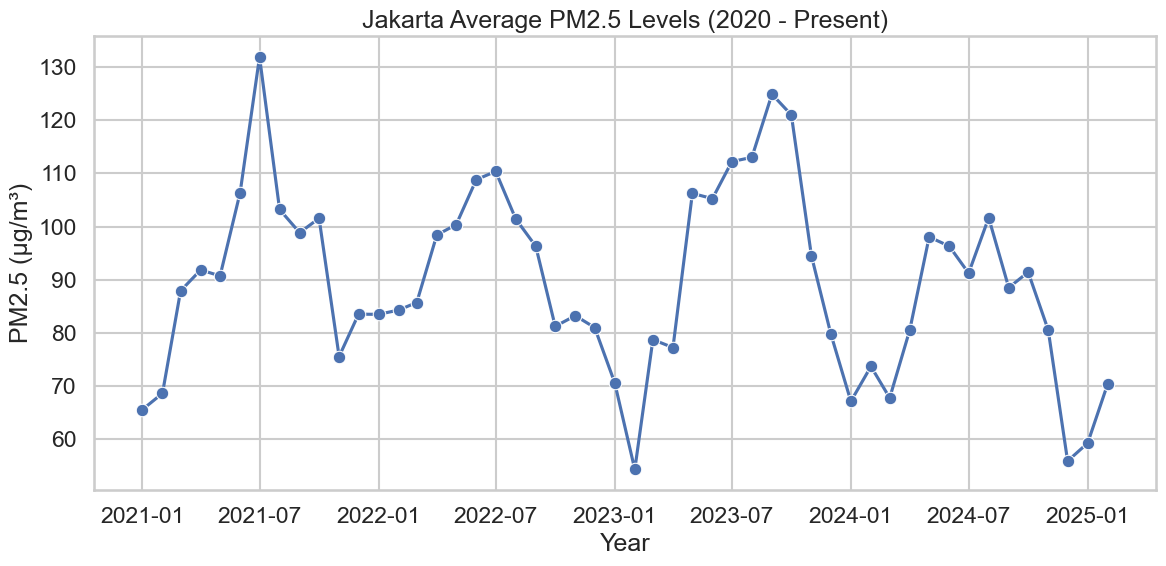

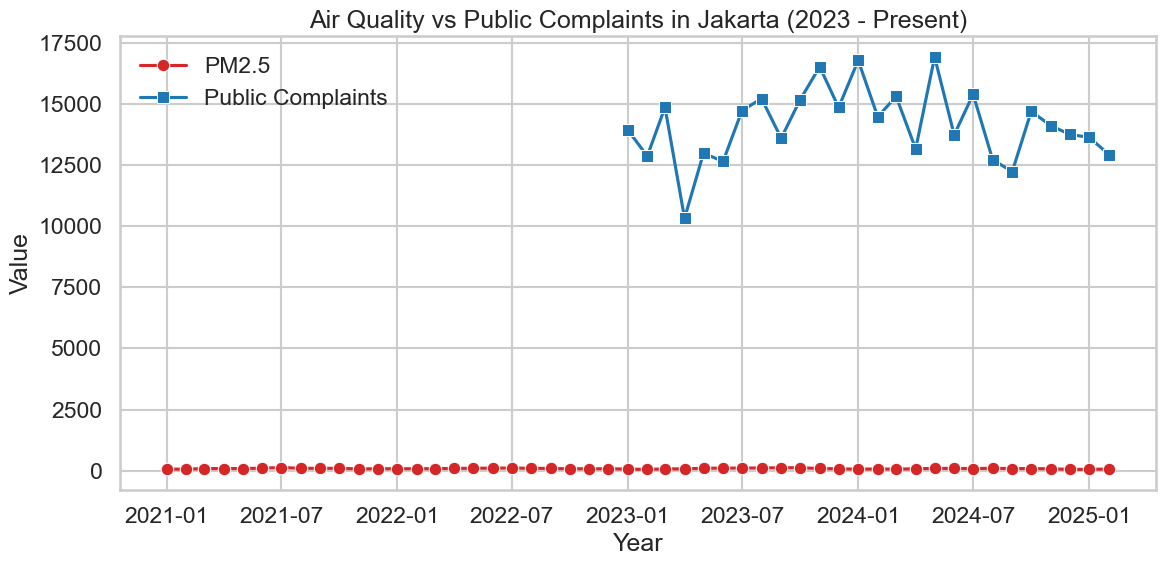

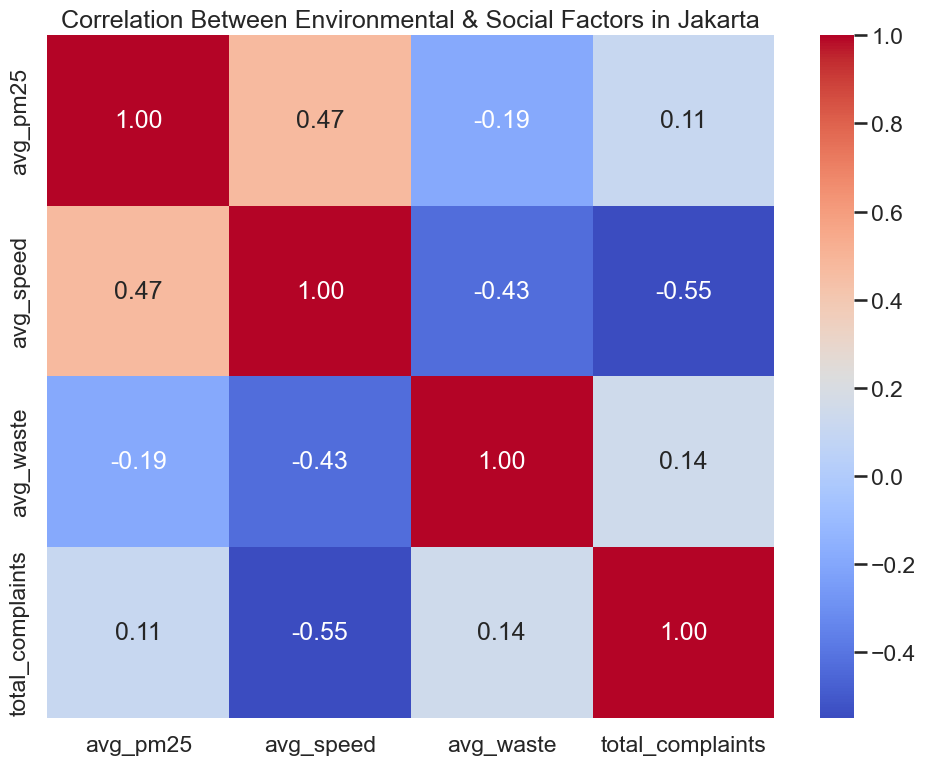

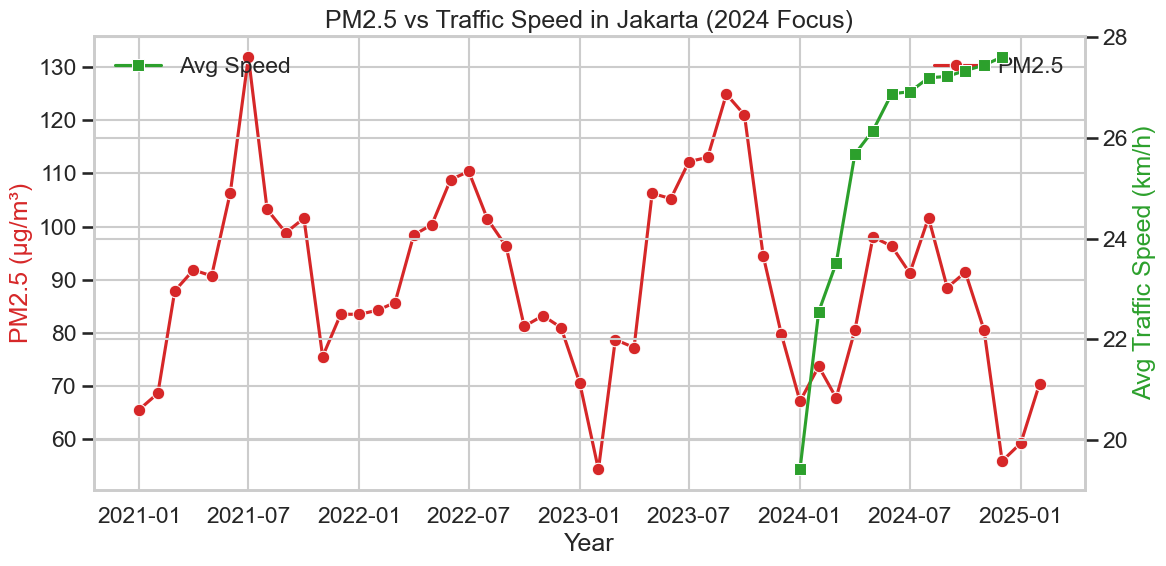

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up style
sns.set(style="whitegrid", context="talk")

# Convert to datetime for smoother plotting
combined['date'] = pd.to_datetime(combined['year'].astype(str) + '-' + combined['month'].astype(str) + '-01')

# === 1. Line plot: Air Quality vs Time ===
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined, x='date', y='avg_pm25', marker='o')
plt.title('Jakarta Average PM2.5 Levels (2020 - Present)')
plt.xlabel('Year')
plt.ylabel('PM2.5 (µg/m³)')
plt.tight_layout()
plt.show()

# === 2. Overlay: PM2.5 vs Public Complaints ===
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined, x='date', y='avg_pm25', label='PM2.5', color='tab:red', marker='o')
sns.lineplot(data=combined, x='date', y='total_complaints', label='Public Complaints', color='tab:blue', marker='s')
plt.title('Air Quality vs Public Complaints in Jakarta (2023 - Present)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# === 3. Scatterplot Matrix (Correlation Overview) ===
plt.figure(figsize=(10, 8))
sns.heatmap(combined[['avg_pm25', 'avg_speed', 'avg_waste', 'total_complaints']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Environmental & Social Factors in Jakarta')
plt.tight_layout()
plt.show()

# === 4. Optional: Dual-axis plot (Air Quality vs Traffic Speed) ===
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
sns.lineplot(data=combined, x='date', y='avg_pm25', ax=ax1, color='tab:red', marker='o', label='PM2.5')
sns.lineplot(data=combined, x='date', y='avg_speed', ax=ax2, color='tab:green', marker='s', label='Avg Speed')

ax1.set_xlabel('Year')
ax1.set_ylabel('PM2.5 (µg/m³)', color='tab:red')
ax2.set_ylabel('Avg Traffic Speed (km/h)', color='tab:green')
plt.title('PM2.5 vs Traffic Speed in Jakarta (2024 Focus)')
plt.tight_layout()
plt.show()
